In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [158]:
path = r"C:\Users\user.DESKTOP-1OSCPEL\Documents\Python\HistoricalPrices.csv"
data = pd.read_csv(path, parse_dates = ['Date'], dayfirst = False, index_col = 'Date')
data.sort_index(inplace=True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2024-01-02,13.70,13.95,13.65,13.75,176500
2024-01-03,13.90,13.90,13.60,13.65,1666700
2024-01-04,13.65,13.80,13.55,13.60,1000500
2024-01-05,13.80,14.00,13.55,13.60,5622200
2024-01-08,13.70,14.00,13.60,13.85,248500


data.isna().sum()

In [160]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2024-01-02,13.70,13.95,13.65,13.75,176500
2024-01-03,13.90,13.90,13.60,13.65,1666700
2024-01-04,13.65,13.80,13.55,13.60,1000500
2024-01-05,13.80,14.00,13.55,13.60,5622200
2024-01-08,13.70,14.00,13.60,13.85,248500
...,...,...,...,...,...
2025-03-27,18.00,18.20,17.90,18.00,1445000
2025-03-28,18.15,18.45,18.00,18.30,9457500
2025-04-01,18.30,18.65,18.20,18.50,13410200


In [161]:
data.columns = data.columns.str.strip()

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2024-01-02 to 2025-04-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    314 non-null    float64
 1   High    314 non-null    float64
 2   Low     314 non-null    float64
 3   Close   314 non-null    float64
 4   Volume  314 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 14.7 KB


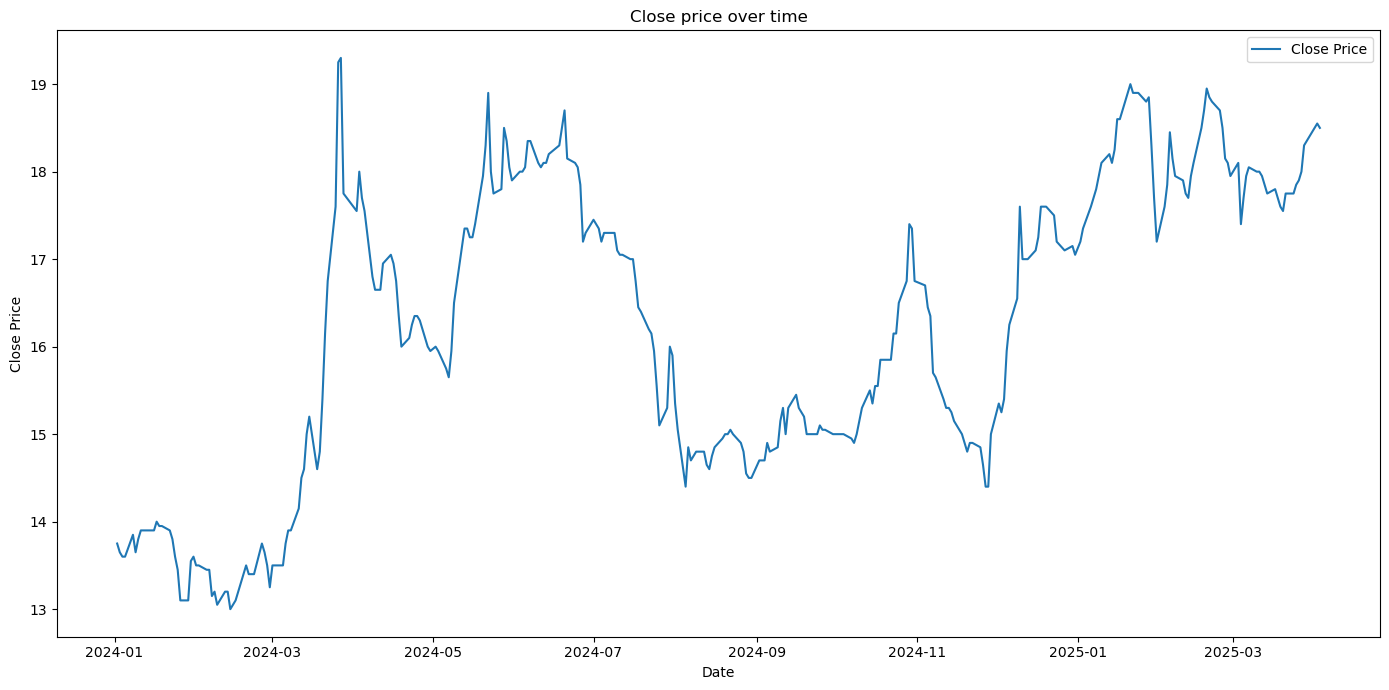

In [163]:
plt.figure(figsize = (14, 7))
plt.plot(data.index, data['Close'], label = 'Close Price')
plt.title("Close price over time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

In [164]:
# Check for stationarity
result = adfuller(data['Close'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p_value: {result[1]:.4f}")
if result[1] < 0.05:
    print("The original series is Stationary")
else:
    print("The original series is NOT Stationary")

ADF Statistic: -1.8300
p_value: 0.3657
The original series is NOT Stationary


Perform Differencing

In [166]:
data['Close_diff'] = data['Close'].diff()
data.head()

,Open,High,Low,Close,Volume,Close_diff
Date,,,,,,
2024-01-02,13.70,13.95,13.65,13.75,176500,NaN
2024-01-03,13.90,13.90,13.60,13.65,1666700,-0.10
2024-01-04,13.65,13.80,13.55,13.60,1000500,-0.05
2024-01-05,13.80,14.00,13.55,13.60,5622200,0.00
2024-01-08,13.70,14.00,13.60,13.85,248500,0.25


In [167]:
result_diff = adfuller(data['Close_diff'].dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p_value: {result[1]:.4f}")
if result_diff[1] < 0.05:
    print("The differenced series is Stationary")
else:
    print("The differenced series is NOT Stationary")

ADF Statistic: -1.8300
p_value: 0.3657
The differenced series is Stationary


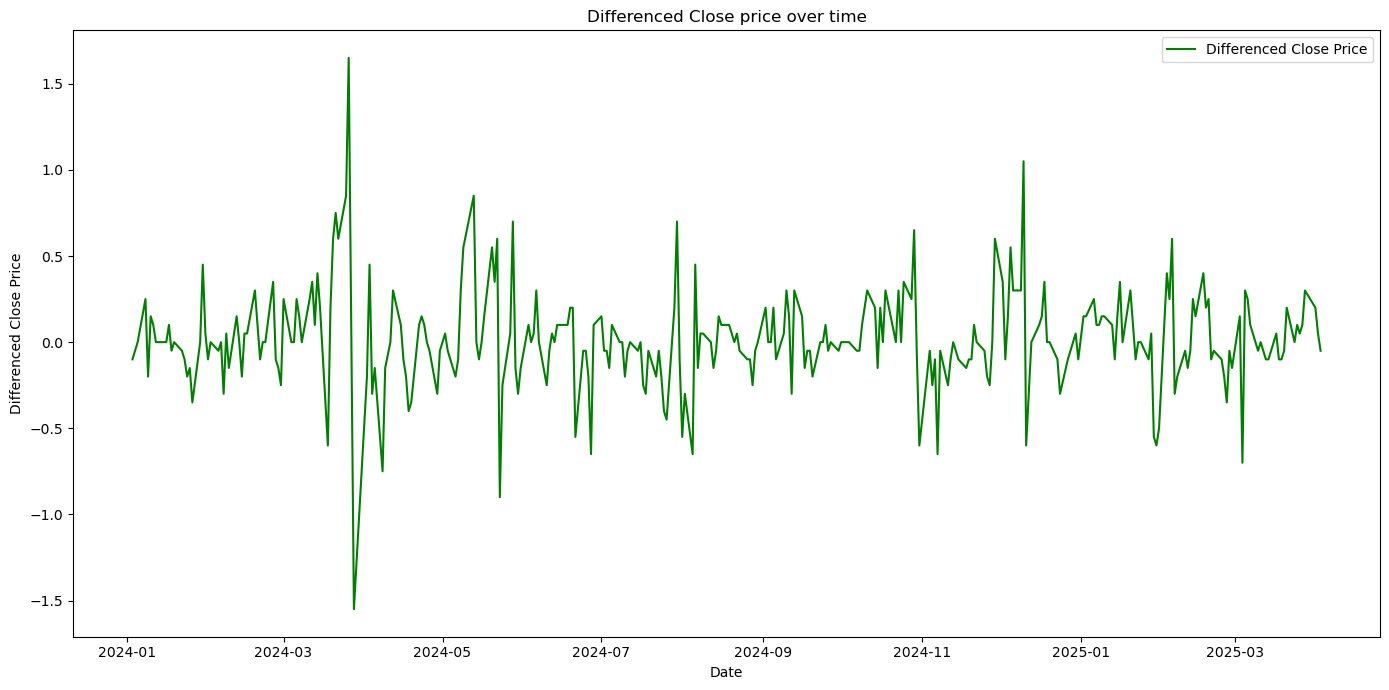

In [168]:
plt.figure(figsize = (14, 7))
plt.plot(data.index, data['Close_diff'], label = 'Differenced Close Price', color = "green")
plt.title("Differenced Close price over time")
plt.xlabel("Date")
plt.ylabel("Differenced Close Price")
plt.legend()
plt.tight_layout()
plt.show()

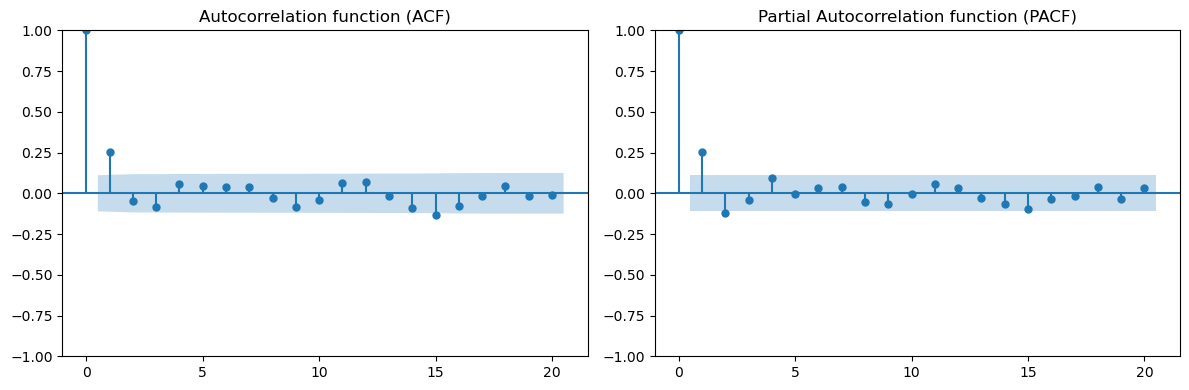

In [169]:
fig, axes =plt.subplots(1, 2, figsize = (12, 4))

#ACF Plot
plot_acf(data['Close_diff'].dropna(), lags = 20, ax = axes[0])
axes[0].set_title('Autocorrelation function (ACF)')
# PACF Plot
plot_pacf(data['Close_diff'].dropna(), lags = 20, ax = axes[1])
axes[1].set_title('Partial Autocorrelation function (PACF)')

plt.tight_layout()
plt.show()

Therefore set the model order as: p = 1, q = 1, d = 1

p - lags for Autogression

d - Differencing

q - Moving Average terms

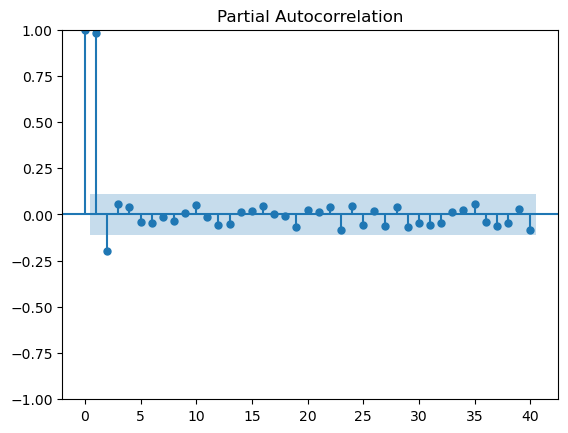

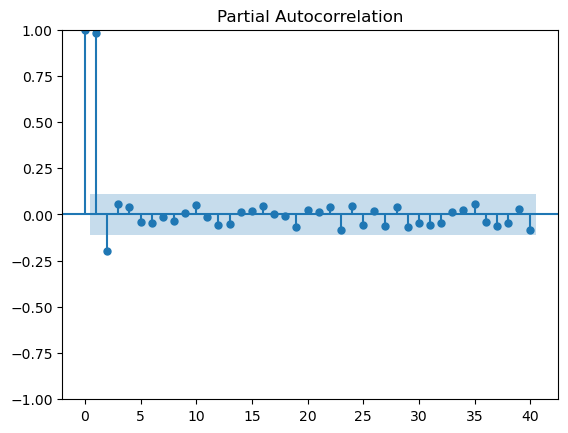

In [211]:
plot_pacf(data["Close"], lags = 40)

#### Forecasting

In [172]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size: ]


In [245]:
model = ARIMA(train["Close"], order = (1, 1, 1))
model_fit = model.fit()

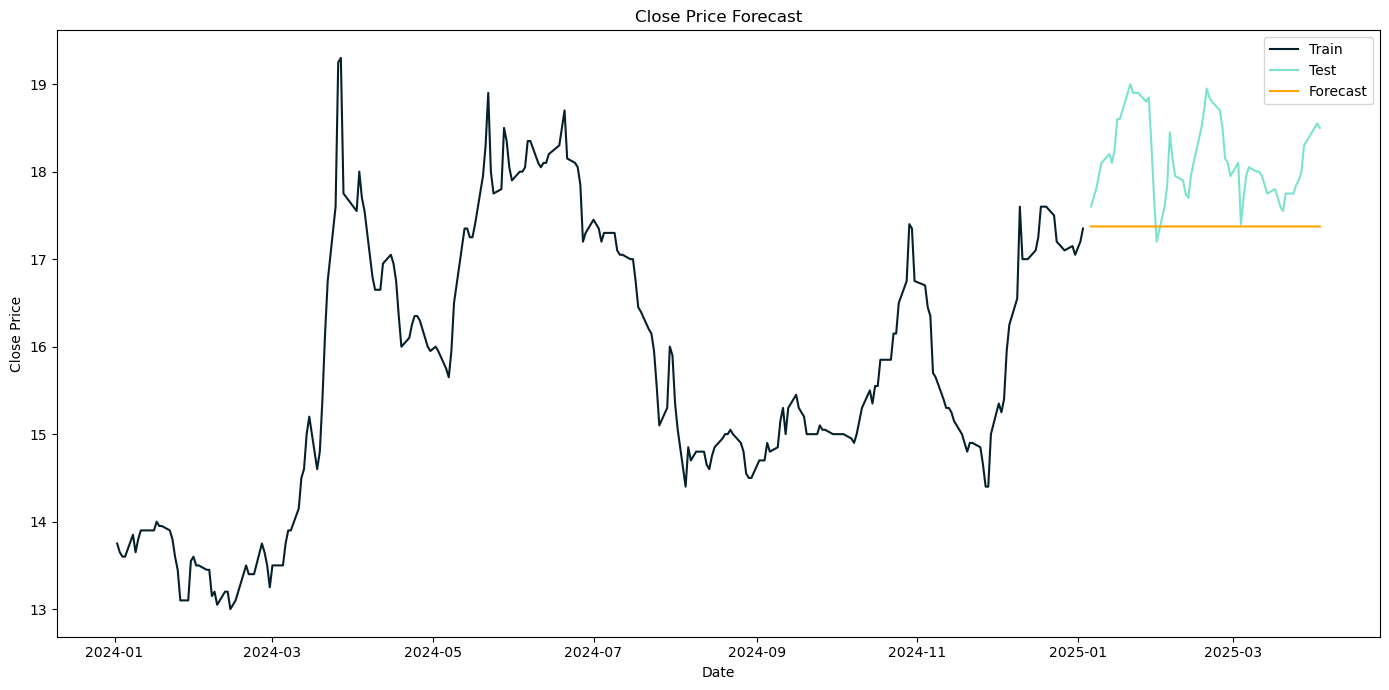

In [246]:
forecast = model_fit.forecast(steps = len(test))
plt.figure(figsize = (14, 7))
plt.plot(train.index, train['Close'], label = 'Train', color = '#06202B')
plt.plot(test.index, test['Close'], label = 'Test', color = '#7AE2CF')
plt.plot(test.index, forecast, label = 'Forecast', color = 'orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

In [247]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 99.09592287136768
BIC: 109.66030562495442


In [248]:
forecast = forecast[:len(test)]
test_close = test['Close'][:len(forecast)]
# RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.8962


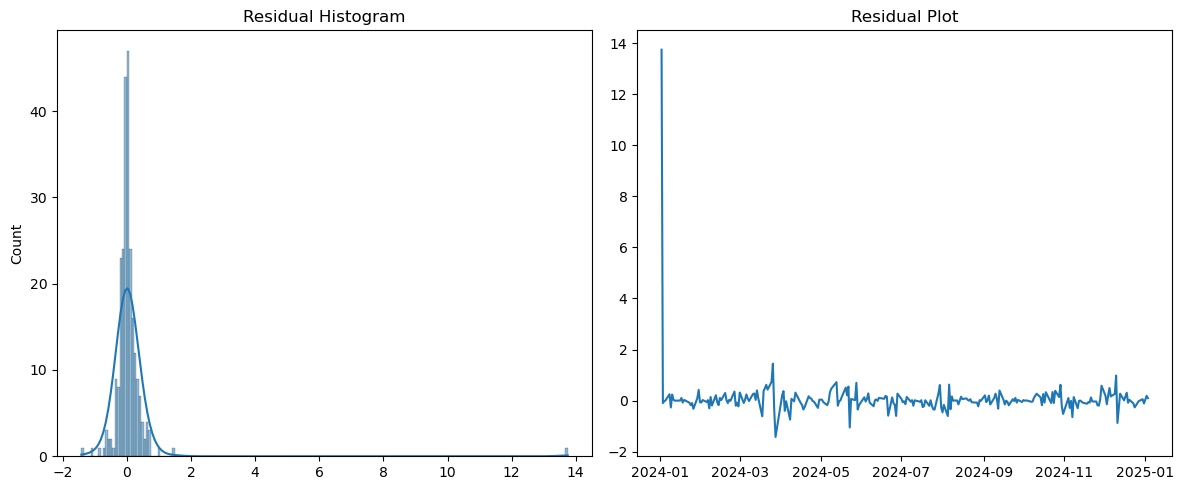

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = model_fit.resid

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residual Histogram')

plt.subplot(1, 2, 2)
plt.plot(residuals)
plt.title('Residual Plot')
plt.tight_layout()
plt.show()
